In [1]:
import sys
sys.path.append("..")

from system_controller import SystemController
from utils import transform_angle_error

import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.integrate import odeint

plt.style.use(["science", "grid"])

# Block on a slope

Try MPPI controller with a simple block on a slope.

In [ ]:
dt = 1 / 10

block_env = BlockOnSlope(
    initial_state=np.array([0.0, 0.0]),
    block_mass=5,
    slope_angle=np.radians(30),
    g=-9.81,
    dt=dt
)

block_env.desired_state = np.array([5, 0])

In [ ]:
# Create lists to store control sequence and state sequences for MPPI runs
control_seq, states = [], []

simulation_length = 8  # s
n_steps = int((1 / dt) * simulation_length)

# Begin simulation
current_state = block_env.initial_state
start_time = perf_counter()

for _ in range(0, n_steps):
    action = block_env.controller.step(current_state)
    current_state = block_env.simulator(current_state, action)
    
    states.append(current_state[0])
    control_seq.append(action)

print("Elapsed Time: {:.5f} s".format(perf_counter() - start_time))

In [ ]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Block on Slope Response")

time = np.linspace(0, simulation_length, n_steps)
ax1.plot(time, states, label="block position")
ax1.plot(time, np.repeat(block_env.desired_state[0], n_steps), label="desired position")
ax1.set(xlabel="time (s)", ylabel="position (m)")
ax1.legend()

ax2.plot(time, control_seq, label="control")
ax2.set(xlabel="time (s)", ylabel="force (N)")

plt.show()

# Pendulum
Try MPPI controller with a pendulum:
![alternatvie text](http://underactuated.mit.edu/figures/simple_pend.svg)

The state-space representation of the system is $x = (\theta, \dot{\theta})$, $u = \tau$, and the dynamics of the inverted pendulum are given by:
$$
\begin{align*}
    \dot{\theta} &= \dot{\theta} \\
    \ddot{\theta} &= \frac{\tau - mgl\sin(\theta) - b\dot{\theta}}{ml^2}
\end{align*}
$$

### Controller Definition

In [ ]:
from systems.dynamical_systems import Pendulum

pend_env = Pendulum(m=1, l=1, b=0.1, dt=1 / 10)

DESIRED_THETA = np.pi
DESIRED_OMEGA = 0.0

# Define the controller cost functions

def terminal_cost(x):
    theta, omega = x
    
    theta_error = transform_angle_error(DESIRED_THETA - theta)
    omega_error = DESIRED_OMEGA - omega

    error = np.array([theta_error, omega_error])
    Q = np.diag([1, 1])

    return error.T @ Q @ error

def state_cost(x):
    theta, omega = x
        
    theta_error = transform_angle_error(DESIRED_THETA - theta)
        
    error = np.array([theta_error])
    Q = np.diag([1])

    return error.T @ Q @ error

pend_controller = SystemController(
    ds=pend_env,
    n_rollouts=200,
    horizon_length=10,
    exploration_cov=np.diag([0.5 ** 2]),
    exploration_lambda=1e-3,
    state_cost=state_cost, terminal_cost=terminal_cost,
    control_range={"min": np.array([-4]), "max": np.array([4])}
).build()

### Simulation Definition

In [ ]:
INITIAL_STATE = np.array([np.radians(0.0), 0.0])

simulation_length = 6  # s
n_steps = int((1 / pend_env.dt) * simulation_length)

# Create lists to store control sequence and state sequences for MPPI runs
controls, states = np.empty((n_steps, pend_env.nu)), np.empty((n_steps, pend_env.nx))

# Begin simulation
current_state = INITIAL_STATE
start_time = perf_counter()

for i in range(0, n_steps):
    action = pend_controller.step(current_state)
    current_state = pend_env.simulator(current_state, action, measurement_noise=False)
    
    states[i] = current_state
    controls[i] = action

print("Elapsed Time: {:.5f} s".format(perf_counter() - start_time))

### Simulation Results

NameError: name 'simulation_length' is not defined

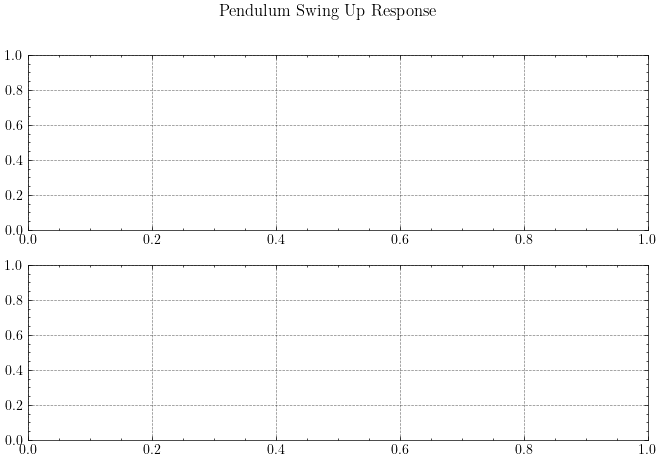

In [2]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

fig.suptitle("Pendulum Swing Up Response")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, states[:, 0], label="Theta")
ax1.set(xlabel="Time (s)", ylabel="Theta (rad)")

ax2.plot(time, states[:, 1], label="Angular ")
ax2.set(xlabel="Time (s)", ylabel="Omega (rad/s)")

plt.tight_layout()

fig.savefig("pendulum_swingup.png")

# Cart-Pole
Try MPPI controller with a cart-pole system:

![alternatvie text](http://underactuated.mit.edu/figures/cartpole.svg)

The state-space representation of the system is $x = (x, \dot{x}, \theta, \dot{\theta})$, $u = f_x$, and the dynamics of the inverted pendulum are given by:
$$
\begin{align*}
    \dot{x} &= \dot{x} \\
    \ddot{x} &= \frac{1}{m_c+m_p\sin^2(\theta)} \left( f_x + m_p\sin(\theta) (l\dot{\theta}^2 + g\cos(\theta)) \right) \\
    \dot{\theta} &= \dot{\theta} \\
    \ddot{\theta} &= \frac{1}{l(m_c+m_p\sin^2(\theta))} \left( -f_x\cos(\theta) - m_p l \dot{\theta}^2 \cos(\theta)\sin(\theta) - (m_c + m_p)g\sin(\theta) \right)
\end{align*}
$$

### Controller Definition

In [41]:
from systems.dynamical_systems import CartPole

cartpole_env = CartPole(m_pole=1, m_cart=1, l=1, dt=1 / 10)

DESIRED_THETA = np.pi
DESIRED_CARTVEL = 0.0

# Define the controller cost functions

def terminal_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = transform_angle_error(DESIRED_THETA - theta)
    vel_error = DESIRED_CARTVEL - posdot

    error = np.array([theta_error, vel_error])
    Q = np.diag([1, 1])

    return error.T @ Q @ error

def state_cost(x):
    return terminal_cost(x)

cartpole_controller = SystemController(
    ds=cartpole_env,
    n_rollouts=100,
    horizon_length=10,
    exploration_cov=np.diag([2 ** 2]),
    exploration_lambda=1e-7,
    terminal_cost=terminal_cost,
    state_cost=state_cost,
    control_range={"min": np.array([-8]), "max": np.array([8])}
).build()

### Simulation Definition

In [42]:
INITIAL_STATE = np.array([0.0, 0.0, np.radians(0.0), 0.0])

simulation_length = 15  # s
n_steps = int((1 / cartpole_env.dt) * simulation_length)

# Create lists to store control sequence and state sequences for MPPI runs
controls, states = np.empty((n_steps, cartpole_env.nu)), np.empty((n_steps, cartpole_env.nx))

# Begin simulation
current_state = INITIAL_STATE
start_time = perf_counter()

for i in range(0, n_steps):
    action = cartpole_controller.step(current_state)
    current_state = cartpole_env.simulator(current_state, action, measurement_noise=False)
    
    states[i] = current_state
    controls[i] = action

print("Elapsed Time: {:.5f} s".format(perf_counter() - start_time))

Elapsed Time: 11.42338 s


### Simulation Results

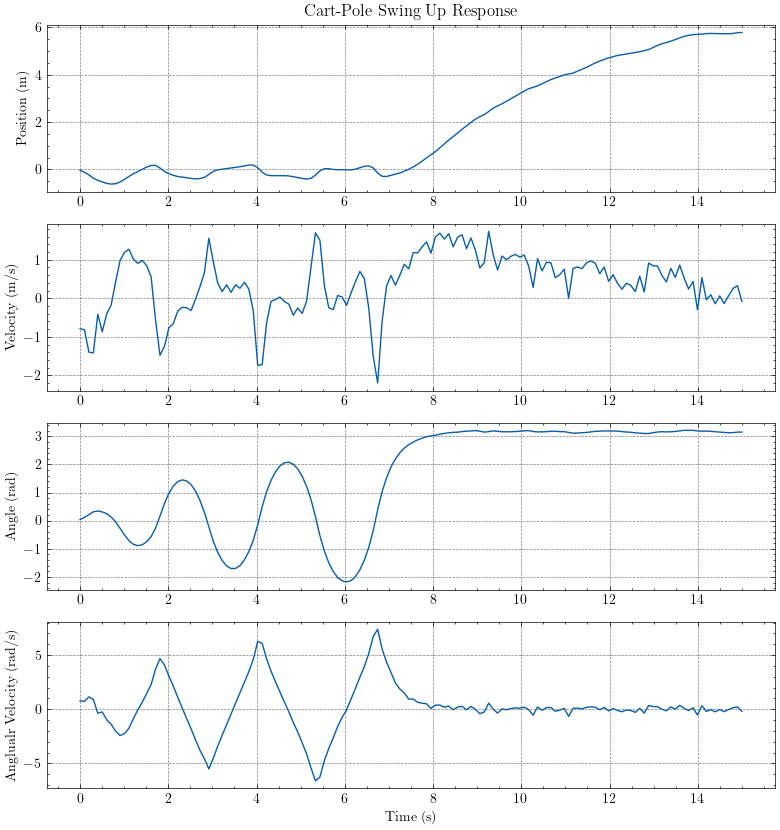

In [43]:
# Plot the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8.5))

# fig.suptitle("Cart-Pole Response")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, states[:, 0])
ax1.set(ylabel="Position (m)", title="Cart-Pole Swing Up Response")

ax2.plot(time, states[:, 1])
ax2.set(ylabel="Velocity (m/s)")

ax3.plot(time, states[:, 2])
ax3.set(ylabel="Angle (rad)")

ax4.plot(time, states[:, 3])
ax4.set(ylabel="Anglualr Velocity (rad/s)")

plt.xlabel("Time (s)")
plt.tight_layout()

fig.savefig("cartpole_swingup.png")